In [277]:
import os
import re
import glob

import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pylab as plt

from torch import nn
from torch.utils.data import DataLoader
from PIL import Image, ImageOps
from IPython.display import display

## Dataset

In [263]:
ALPHABET_SIZE = 10 + 26


def encode_text(s):
    assert s.isalnum() and len(s) == 5
    return [
        ord(c) + (10 - ord('a') if c.isalpha() else - ord('0'))
        for c in s
    ]


def decode_text(arr):
    assert all(val >= 0 and val < ALPHABET_SIZE for val in arr)
    return ''.join(
        chr(val + (ord('0') if val < 10 else ord('a') - 10))
        for val in arr
    )

class CaptchasDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.X, self.y = [], []
        for fname in glob.iglob(os.path.join(path, '*.png')):
            with Image.open(fname) as img:
                x = torch.tensor(np.array(ImageOps.grayscale(img), dtype=np.float32) / 256.)
                self.X.append(x.reshape(1, *x.size()))

            label = os.path.splitext(os.path.basename(fname))[0]
            self.y.append(torch.LongTensor(encode_text(label)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def load_train_test_datasets(dataset_path, test_ratio):
    dataset = CaptchasDataset(dataset_path)
    test_length = int(np.ceil(len(dataset) * test_ratio))  # NOTE: can't use fractions
    return torch.utils.data.random_split(dataset, [len(dataset) - test_length, test_length])

## Model

In [234]:
NUM_CHARS = 5


class FCN_MLP_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcn = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 32, (3, 3)), nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3)), nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, (3, 3)), nn.MaxPool2d((2, 2)),
            nn.Conv2d(128, 128, (3, 3)), nn.MaxPool2d((2, 2)),
            nn.Flatten(),
        )
        self.mlp = nn.Sequential(
            nn.Linear(1280, 160 * 5),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(160 * 5, 5 * ALPHABET_SIZE),
        )
    def forward(self, X):
        return self.mlp(self.fcn(X)).view(X.size(0), 5, -1)


## Training & Validation

In [245]:
class LitModel(pl.LightningModule):
    def __init__(self, torch_model):
        super().__init__()
        self.torch_model = torch_model

    def training_step(self, batch, batch_idx):
        x, target = batch
        z = self.torch_model(x)
        return sum([F.cross_entropy(z[:,i], target[:,i]) for i in range(5)]) / target.size(1)

    def validation_step(self, batch, batch_idx):
        x, target = batch
        y = self.torch_model(x)
        val_loss = sum([F.cross_entropy(y[:,i], target[:,i]) for i in range(5)]) / 5
        val_cer = sum((torch.argmax(y[:,i], 1) != target[:,i]).sum() for i in range(5)) / (5 * x.size(0))

        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_cer', val_cer, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)

In [236]:
torch.manual_seed(2023)
train_dataset, test_dataset = load_train_test_datasets('./captchas', 0.2)
model = LitModel(FCN_MLP_Model())

In [237]:
trainer = pl.Trainer(
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_cer', min_delta=0.00, patience=25, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(save_top_k=3, monitor='val_cer'),
    ],
    # resume_from_checkpoint
)
trainer.fit(model, DataLoader(train_dataset, num_workers=12, batch_size=32), DataLoader(test_dataset, batch_size=2048))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type          | Params
----------------------------------------------
0 | torch_model | FCN_MLP_Model | 1.4 M 
----------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.637     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved. New best score: 0.905


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.117 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.189 >= min_delta = 0.0. New best score: 0.598


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.177 >= min_delta = 0.0. New best score: 0.421


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.059 >= min_delta = 0.0. New best score: 0.363


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.030 >= min_delta = 0.0. New best score: 0.333


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.030 >= min_delta = 0.0. New best score: 0.303


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.028 >= min_delta = 0.0. New best score: 0.275


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.006 >= min_delta = 0.0. New best score: 0.269


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.024 >= min_delta = 0.0. New best score: 0.245


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.014 >= min_delta = 0.0. New best score: 0.231


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.005 >= min_delta = 0.0. New best score: 0.226


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.007 >= min_delta = 0.0. New best score: 0.219


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.016 >= min_delta = 0.0. New best score: 0.203


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.001 >= min_delta = 0.0. New best score: 0.202


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.015 >= min_delta = 0.0. New best score: 0.187


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.004 >= min_delta = 0.0. New best score: 0.183


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.001 >= min_delta = 0.0. New best score: 0.182


Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.012 >= min_delta = 0.0. New best score: 0.170


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.006 >= min_delta = 0.0. New best score: 0.164


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_cer improved by 0.003 >= min_delta = 0.0. New best score: 0.162


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_cer did not improve in the last 25 records. Best score: 0.162. Signaling Trainer to stop.


## Analysis

In [244]:
best_model = LitModel.load_from_checkpoint(
    './lightning_logs/version_113/checkpoints/epoch=112-step=2937.ckpt',
    torch_model=FCN_MLP_Model(),
)

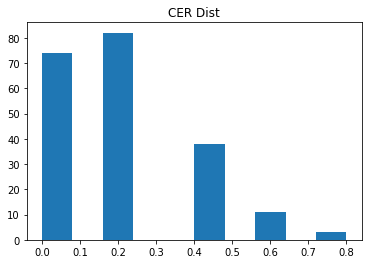

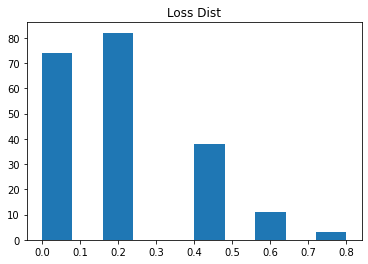

Worst by CER
mmp72


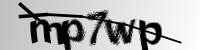

4np57


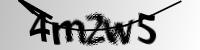

y2nxg


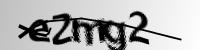

56xnf


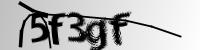

w48cw


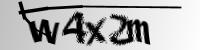


Worst by Loss
56xnf


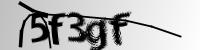

mmp72


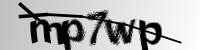

wdmcw


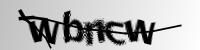

w48cw


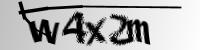

4np57


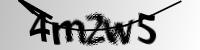

In [284]:
def calc_worst(model, dataset):
    losses, cers = [], []
    preds, targets = [], []
    for x, target in DataLoader(dataset):
        y = model.torch_model(x)
        losses.append(float(sum([F.cross_entropy(y[:,i], target[:,i]) for i in range(5)]) / 5))
        preds.append(decode_text(torch.argmax(y.view(5, -1), 1)))
        targets.append(decode_text(target.view(-1)))
        cer = sum((torch.argmax(y[:,i], 1) != target[:,i]).sum() for i in range(5))
        cers.append(float(cer) / (5 * x.size(0)))
    
    plt.title('CER Dist')
    plt.hist(cers)
    plt.show()
    
    plt.title('Loss Dist')
    plt.hist(cers)
    plt.show()
    
    worst_cers = torch.topk(torch.tensor(cers), 5)[1]
    worst_losses = torch.topk(torch.tensor(losses), 5)[1]
    
    print('Worst by CER')
    for i in worst_cers:
        with Image.open(f'./captchas/{targets[i]}.png') as img:
            print(preds[i])
            display(img)
    
    print()
    print('Worst by Loss')
    for i in worst_losses:
        with Image.open(f'./captchas/{targets[i]}.png') as img:
            print(preds[i])
            display(img)


calc_worst(model, test_dataset)

## Анализ

Плохо различает похожие буквы при искажениях. Ошибки чаще в районе "блюра". Можно расширить датасета, дополнительно добавив adjustment-а размытием.

(Предполагаемые) Регионы распознания соседних символов иногда "накладываются" друг на друга. Можно заменить MLP на RNN.